# Mod 2 Project Visualization and Hypothesis Testing Notebook
### Amir Edris, Ben Inoyatov
---

In [30]:
!pwd

/Users/bensioninoyatov/mod_2_project_repo/Mod-2-Project


In [77]:
# importing the standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pandas_profiling import ProfileReport
from statsmodels.formula.api import ols
import scipy.stats as stats
import pickle as pkl

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

### Importing cleaned datasets from the ```data_cleaning``` notebook 

In [65]:
# features and feature dfs
features = pkl.load(open('features.pkl','rb'))
m_feature = pkl.load(open('m_feature.pkl','rb'))
p_feature = pkl.load(open('p_feature.pkl','rb'))


# original data set for math class
m_orig = pd.read_csv('MathClassOriginal.csv')
m_orig = m_orig.drop('Unnamed: 0',axis =1)

# original dataset for language arts class
p_orig = pd.read_csv('PortugeseClassOriginal.csv')
p_orig = p_orig.drop('Unnamed: 0',axis =1)

# cleaned dfs with all values 
m = pd.read_csv('MathClassCleaned.csv')
m = m.drop(columns='Unnamed: 0')
p = pd.read_csv('PortugeseClassCleaned.csv')
p = p.drop(columns='Unnamed: 0')

In [66]:
m.shape

(395, 41)

In [67]:
# one df with all variables in numeric values to use for anaylsis 
p_dummy = pd.get_dummies(p, columns=['guardian'])
p_dummy.drop(columns=['guardian_other'], inplace=True)
p_dummy = pd.get_dummies(p_dummy, columns=['school'], drop_first=True, prefix='school')

m_dummy = pd.get_dummies(m, columns=['guardian'])
m_dummy.drop(columns=['guardian_other'], inplace=True)
m_dummy = pd.get_dummies(m_dummy, columns=['school'], drop_first=True, prefix='school')

p_dummy = pd.get_dummies(p_dummy, columns=['sex'], drop_first=True)
m_dummy = pd.get_dummies(m_dummy, columns=['sex'], drop_first=True)

### Making a correlation matrix for our cleaned datasets
- Take note of the relationship between G1, G2 and G3

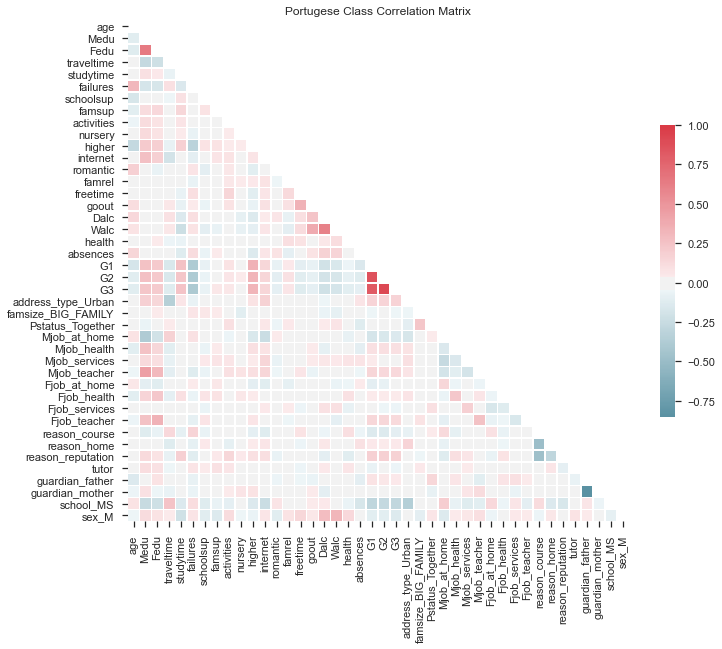

In [5]:
sns.set(style='ticks')

# Compute the correlation matrix
corr = p_dummy.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Portugese Class Correlation Matrix')
plt.show;
plt.savefig('p_corr_matrix.png')

### Now for the Math class
- Similiar correlations

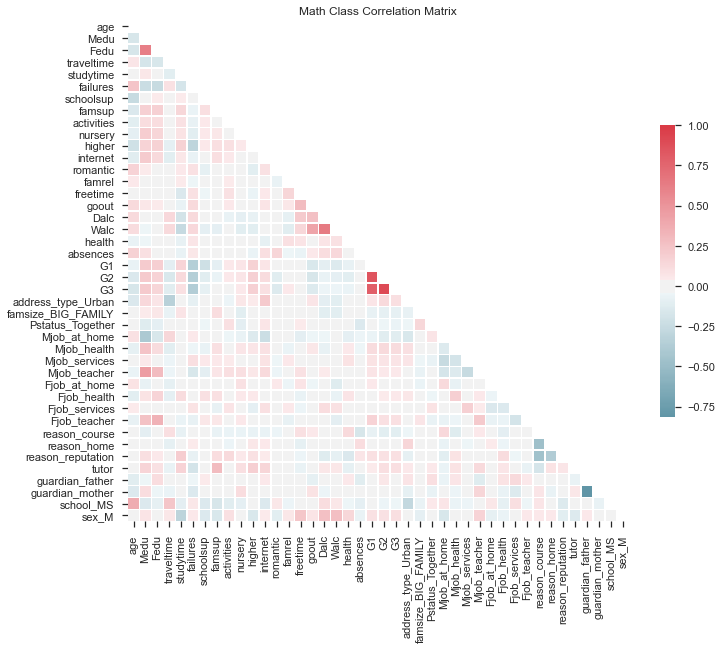

In [6]:
sns.set(style='ticks')

# Compute the correlation matrix
corr = m_dummy.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Math Class Correlation Matrix')
plt.show;
plt.savefig('m_corr_matrix.png')

## EDA
--- 
#### Taking a look at the distribution of our target variable, G3, for both classes

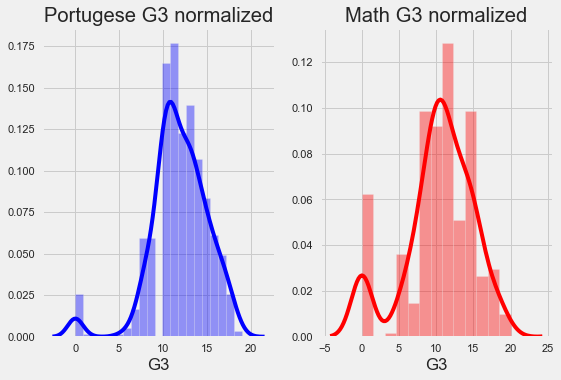

In [43]:
fig, (ax, ax1) = plt.subplots(nrows=1,ncols=2)

sns.distplot(p_orig.G3,label='Portugese', ax=ax, color='blue')
sns.distplot(m_orig.G3, label='Math', ax=ax1, color='red')
ax.set_title('Portugese G3 normalized')
ax1.set_title('Math G3 normalized')
plt.tight_layout()
plt.savefig('g3_distplot.png')
plt.show();

#### Are the two class averages significantly different? 

In [44]:
math_g3 = m_dummy.G3
port_g3 = p_dummy.G3

# anova due to different sizes of math and port classes
t_stat, pval = stats.f_oneway(port_g3,math_g3)
print(f'T-stat: {t_stat}, p-value: {pval}')
print('P-value very low, below alpha level of .05, we reject the null. These two classes seem to have') 
print('statistically significant different average G3 scores. Math seems to be the harder subject')

T-stat: 37.82756114828064, p-value: 1.0998219243725637e-09
P-value very low, below alpha level of .05, we reject the null. These two classes seem to have
statistically significant different average G3 scores. Math seems to be the harder subject


#### Math and Portugese have statistically different average grades with math seeming to be the harder subject
---
#### Now for some interesting attributes

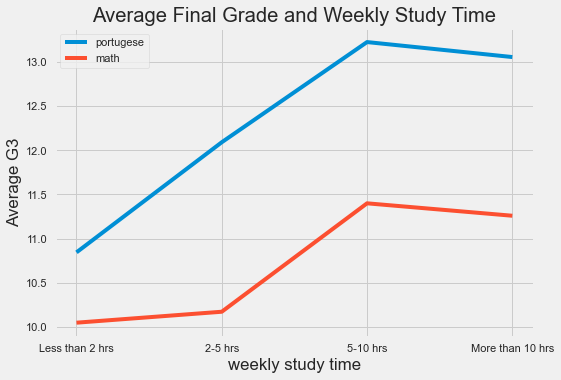

In [45]:
# study time 
p_dummy.groupby('studytime')['G3'].mean().plot(label='portugese')
m_dummy.groupby('studytime')['G3'].mean().plot(label='math')
plt.ylabel('Average G3')
plt.xticks([1,2,3,4], labels=['Less than 2 hrs', '2-5 hrs', '5-10 hrs', 'More than 10 hrs'])
plt.xlabel('weekly study time')
plt.title('Average Final Grade and Weekly Study Time')

plt.legend()
plt.tight_layout();

plt.savefig('g3_studytime.png')
plt.show;

#### Our inference from this graph is that student's who study > 10 hrs might be ones who struggle in classes to begin with. It is interesting to note that for both classes the average final grade decreased when over 10 hrs study time however you can see it increases as hours of study time goes up. 
---

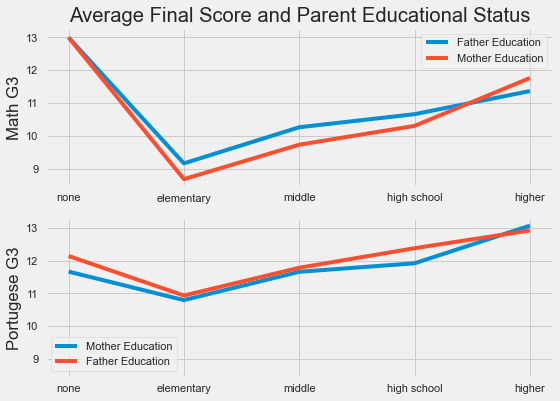

In [46]:
# looking at education level of the parents 

fmmean = m.groupby('Fedu')['G3'].mean() # father education - math mean
mmmean = m.groupby('Medu')['G3'].mean() # mother education - math mean
fpmean = p.groupby('Fedu')['G3'].mean() # father - portugese
mpmean = p.groupby('Medu')['G3'].mean() # mother - portugese

fig, (ax, ax1) = plt.subplots(2, sharey=True)
ax.plot(fmmean, label='Father Education');
ax.plot(mmmean, label='Mother Education');
ax1.plot(mpmean, label='Mother Education');
ax1.plot(fpmean, label='Father Education');

ax.set_ylabel('Math G3')
ax.set_xticklabels(['none', 'elementary', 'middle', 'high school', 'higher'])
ax.set_xticks(ticks=[0,1,2,3,4])

ax1.set_ylabel('Portugese G3')
ax1.set_xticks(ticks=[0,1,2,3,4])
ax1.set_xticklabels(['none', 'elementary', 'middle', 'high school', 'higher'])

ax.legend()
ax1.legend()
plt.tight_layout();
plt.savefig('medu_fedu_g3_mean.png')
ax.set_title('Average Final Score and Parent Educational Status')
plt.show;

- We have grades for students whose parents' have 'none' as their education level. We must remember that this data was acquired by questionarre which leaves to error bias.  
- We will now do T-Tests between mother and father education for each class and between classes

In [47]:
# two pair t test showing that there is no significant difference between the two parents education level and mean math G3 score
t_stat, pval =  stats.ttest_rel(fmmean,mmmean)
print('Math: ')
print(f'T-Stastic: {t_stat}, p-value: {pval}')
print('Fail to reject null hypothesis')
print('\r')

# same test for portugese, two pair t test because both variables are portugese 
t_stat, pval =  stats.ttest_rel(fpmean,mpmean)
print('Portugese: ')
print(f'T-Stastic: {t_stat}, p-value: {pval}')
print('Fail to reject null hypothesis')
print('\r')

# ANOVA test showing that there is no significant difference between the two parents education level and mean math G3 score
t_stat, pval = stats.f_oneway(fpmean,fmmean)
print('Father across classes: ')
print(f'T-Stastic: {t_stat}, p-value: {pval}')
print('Fail to reject null hypothesis')
print('\r')

# same test for portugese, using ANOVA here due to different sizes of math and portugese classes
t_stat, pval = stats.f_oneway(mpmean,mmmean)
print('Mother across classes: ')
print(f'T-Stastic: {t_stat}, p-value: {pval}')
print('Fail to reject null hypothesis')


Math: 
T-Stastic: 1.110327491772108, p-value: 0.32910493677320324
Fail to reject null hypothesis

Portugese: 
T-Stastic: 1.8015606402508362, p-value: 0.1459730755904162
Fail to reject null hypothesis

Father across classes: 
T-Stastic: 2.5419582669892633, p-value: 0.1495232577797088
Fail to reject null hypothesis

Mother across classes: 
T-Stastic: 1.7839742336158637, p-value: 0.21841157684509815
Fail to reject null hypothesis


#### Inferences: since we failed to reject all our nulls, we cannot conclude that parent's education level shows a signifcant change in average scores.
---

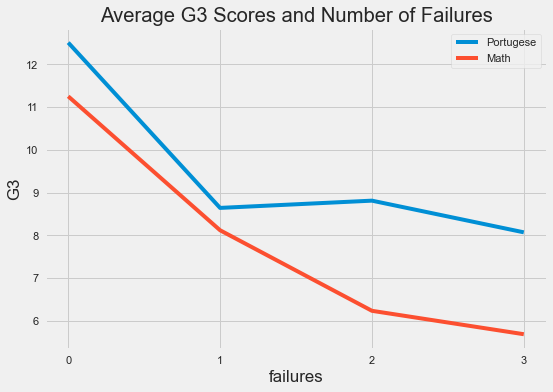

In [48]:
# Failures
a = p.groupby('failures')['G3'].mean()
b = m.groupby('failures')['G3'].mean()
a.plot(label='Portugese')
b.plot(label='Math')
plt.ylabel('G3')
plt.title("Average G3 Scores and Number of Failures")
plt.xticks([0,1,2,3])
plt.savefig('g_fails.png');
plt.legend()
plt.show;

In [49]:
a=p_dummy[p_dummy['failures'] == 3]['G3']
b=p_dummy[p_dummy['failures'] == 0]['G3']
t,p = stats.f_oneway(a,b)
t,p

(33.63362014887464, 1.1119355196447986e-08)

#### A very small p-value, we reject that there is no relationshup between having more failures and your G3 score. From our data, having even one failure was detrimental to the final score

### Plotting the distribution of those failures

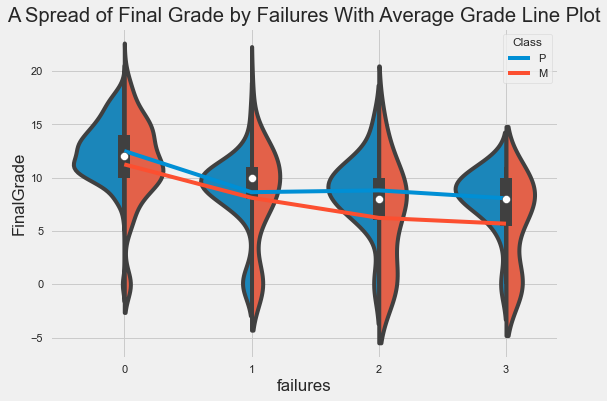

In [50]:
JointFailData = list(p_dummy.failures)
JointGradeData = list(p_dummy.G3)
JointClassType = ['P' for x in JointFailData]
mathtuples = list(zip(list(m_dummy.failures),list(m_dummy.G3)))

for i,v in mathtuples:
    JointFailData.append(i)
    JointGradeData.append(v)
    JointClassType.append('M')
jointlist = list(zip(JointFailData,JointGradeData,JointClassType))

jointdf = pd.DataFrame(data = jointlist, columns = ['Failures','FinalGrade','Class'])
jointdf

ax = sns.violinplot(x="Failures", y="FinalGrade", hue="Class", split=True, data=jointdf)
j = p_dummy.groupby('failures')['G3'].mean()
k = m_dummy.groupby('failures')['G3'].mean()
j.plot()
k.plot()
plt.tight_layout();

plt.savefig('violinplot_g3_failures.png')
plt.title('A Spread of Final Grade by Failures With Average Grade Line Plot')
plt.show;

---
#### Sentiment on going to further Higher Education 

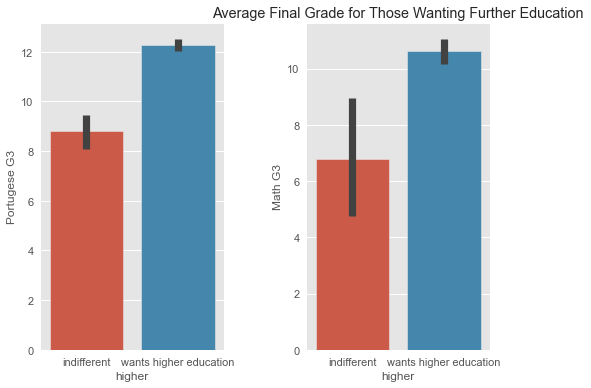

In [79]:
# Average score for those who want to go on to higher education vs those who do not 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
sns.barplot(x=p_feature.higher, y=p_orig.G3, label='Portugese', ax=ax1);
sns.barplot(x=m_feature.higher, y=m_orig.G3, label='Math', ax=ax2);
ax1.set_xticks(ticks=[0,1])
ax1.set_xticklabels(labels=['indifferent', 'wants higher education'])
ax2.set_xticks(ticks=[0,1])
ax2.set_xticklabels(labels=['indifferent', 'wants higher education'])
ax1.set_ylabel('Portugese G3')
ax2.set_ylabel('Math G3')

plt.title('Average Final Grade for Those Wanting Further Education')

plt.tight_layout();

plt.savefig('higher_mean_g3.png')
plt.show;

In [52]:
# t test for the above
ind = p_dummy[p_dummy['higher'] == 0]['G3']
wants = p_dummy[p_dummy['higher']==1]['G3']

t_stat, pval =  stats.ttest_ind(wants,ind)
print('Null Hypothesis: A desire for higher education has no affect on your average G3 score')
print('Alternative: There is an affect on your final grade if you want a higher education')
print('\n')
print(f'T-Stat: {t_stat}, p-value: {pval}')
print('Reject the null')

Null Hypothesis: A desire for higher education has no affect on your average G3 score
Alternative: There is an affect on your final grade if you want a higher education


T-Stat: 8.957815184466758, p-value: 3.499659592830118e-18
Reject the null


#### Very small p-value, we reject the null. Students who want to go on to higher education trend towards higher average scores. 
---

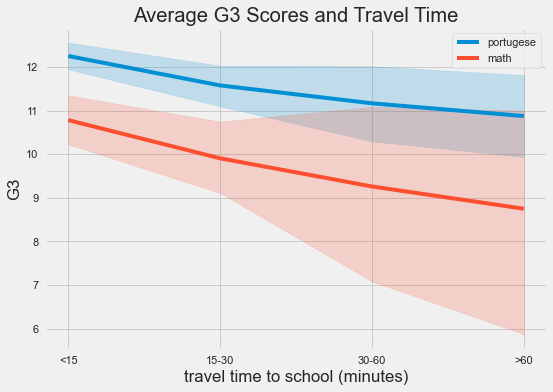

In [53]:
# travel time to school
a = p_dummy.groupby('traveltime')['G3'].mean()
b = m_dummy.groupby('traveltime')['G3'].mean()
sns.lineplot(x=p_dummy.traveltime, y=p_dummy.G3, label='portugese')
sns.lineplot(x=m_dummy.traveltime, y=m_dummy.G3, label='math')
# a.plot(label='Portugese')
# b.plot(label='Math')
plt.ylabel('G3')
plt.title('Average G3 Scores and Travel Time')
plt.xlabel('travel time to school (minutes)')
plt.xticks([1,2,3,4], ['<15', '15-30', '30-60', '>60'])
plt.savefig('averge_g3_traveltime.png');
plt.legend()
plt.show;

In [54]:
sixty_mean_math = m_dummy[m_dummy['traveltime']>3]['G3']
fift_mean_math = m_dummy[m_dummy['traveltime']<2]['G3']

t_stat, pval =  stats.ttest_ind(sixty_mean_math, fift_mean_math)
print(t_stat, pval)
print('Null: There is no relationship between travel time for your math/portugese grade')
print('With a high p-value, we fail to reject this null.')
print('\r')
mean_port_sixty = p_dummy[p_dummy['traveltime']>3]['G3']
fift_mean_math = p_dummy[p_dummy['traveltime']<2]['G3']
t_stat, pval = stats.ttest_ind(mean_port_sixty, fift_mean_math)
print(t_stat, pval)
print('Fail to reject null')

-1.2555264613701276 0.21040203728657364
Null: There is no relationship between travel time for your math/portugese grade
With a high p-value, we fail to reject this null.

-1.751162181311097 0.08072480308913296
Fail to reject null


#### This finding was very intresting. There was no statistically signifcant difference of final grades if your travel time was more or less
---

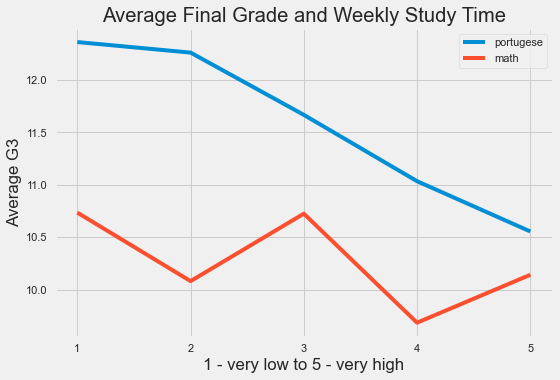

In [55]:
# weekend alcohol consumption (1-5, 5 being very high)
p_dummy.groupby('Walc')['G3'].mean().plot(label='portugese')
m_dummy.groupby('Walc')['G3'].mean().plot(label='math')
plt.ylabel('Average G3')
plt.xticks([1,2,3,4,5])
plt.xlabel('1 - very low to 5 - very high')
plt.title('Average Final Grade and Weekly Study Time')

plt.legend()
plt.tight_layout()

plt.savefig('walc_g3.png')
plt.show;

#### For Portugese, the average G3 score went down quite a lot but for the math class it seemed to go back and forth. 
---

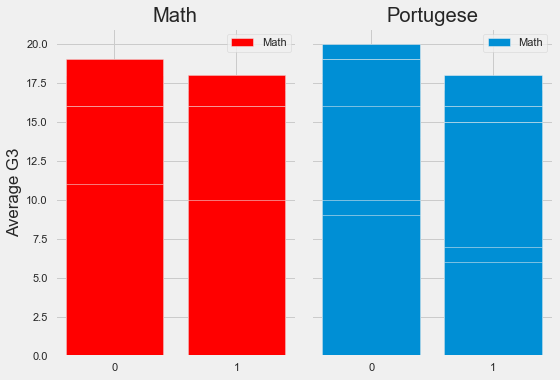

In [56]:
# romantic relationship
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

ax.bar(p_dummy['romantic'], height=p_dummy['G3'], label='portugese', color='red')
ax1.bar(m_dummy['romantic'], height=m_dummy['G3'], label='math')

ax.set_ylabel('Average G3')
ax.set_title('Math')
ax1.set_title('Portugese')
ax.set_xticks([0,1])
ax1.set_xticks([0,1])
ax.legend(['Math', 'Portugese'])
ax1.legend(['Math', 'Portugese'])

plt.tight_layout()
plt.savefig('romantic.png')
plt.show;

### Students received lower grades for both Math and Portugese when in a romantic relationship. 
---


## Final Thoughts on EDA
- The more and more we worked with this data, the more we realized its best to use classification techniques and other machine learning topics like random forests and decision trees. 
- Many attributes we thought affected school performance turned out to suprise us when we saw our results. 

### Basic OLS regression models for both df's using p_feature and m_feature 
- These are highly colinear models and our regression notebook will dive into more detail but added this hear to see the breakdown
- Refer to the Regression notebook for further analysis

In [58]:
pnew_feat = [i for i in p_feature.columns]

In [22]:
mnew_feat = [i for i in m_feature.columns]

In [23]:
p_dummy

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,address_type_Urban,famsize_BIG_FAMILY,Pstatus_Together,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,tutor,guardian_father,guardian_mother,school_MS,sex_M
0,18,4,4,2,2,0,1,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,17,1,1,1,2,0,0,1,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,15,1,1,1,2,0,1,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,15,4,2,1,3,0,0,1,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
4,16,3,3,1,2,0,0,1,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,19,2,3,1,3,1,0,0,1,0,1,1,0,5,4,2,1,2,5,4,10,11,10,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0
645,18,3,1,1,2,0,0,1,0,1,1,1,0,4,3,4,1,1,1,4,15,15,16,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0
646,18,1,1,2,2,0,0,0,1,1,1,0,0,1,1,1,1,1,5,6,11,12,9,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
647,17,3,1,2,1,0,0,0,0,0,1,1,0,2,4,5,3,4,2,6,10,10,10,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1


In [24]:
pfeatlist = '+'.join(pnew_feat)
mfeatlist = '+'.join(mnew_feat)
pfeatlist

'Medu+Fedu+traveltime+studytime+failures+schoolsup+famsup+activities+nursery+higher+internet+romantic+famrel+freetime+goout+Dalc+Walc+health+absences+address_type_Urban+famsize_BIG_FAMILY+Pstatus_Together+Mjob_at_home+Mjob_health+Mjob_services+Mjob_teacher+Fjob_at_home+Fjob_health+Fjob_services+Fjob_teacher+reason_course+reason_home+reason_reputation+tutor+guardian_father+guardian_mother+school_MS+super'

In [25]:
print('Portugese Class')
model = ols(data = p_dummy,formula='G3~Medu+Fedu+traveltime+studytime+failures+schoolsup+famsup+activities+nursery+higher+internet+romantic+famrel+freetime+goout+Dalc+Walc+health+absences+address_type_Urban+famsize_BIG_FAMILY+Pstatus_Together+Mjob_at_home+Mjob_health+Mjob_services+Mjob_teacher+Fjob_at_home+Fjob_health+Fjob_services+Fjob_teacher+reason_course+reason_home+reason_reputation+tutor+guardian_father+guardian_mother+school_MS').fit()
model.summary()

Portugese Class


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     8.911
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           2.32e-37
Time:                        18:03:22   Log-Likelihood:                -1541.4
No. Observations:                 649   AIC:                             3159.
Df Residuals:                     611   BIC:                             3329.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.2275      1.141      9.839      0.000       8.986      13.468
Medu                   0.0083      0.152      0.055      0.956      -0.290       0.306
Fedu                   0.1691      0.139      1.220      0.223      -0.103       0.441
traveltime             0.0144      0.159      0.090      0.928      -0.299       0.327
studytime              0.4740      0.139      3.409      0.001       0.201       0.747
failures              -1.3694      0.199     -6.884      0.000      -1.760      -0.979
schoolsup             -1.2988      0.360     -3.606      0.000      -2.006      -0.592
famsup                 0.0069      0.226      0.030      0.976      -0.437       0.451
activities             0.1332      0.223      0.597      0.550      -0.305       0.571
nursery               -0.1790      0.273     -0.656      0.512      -0.715       0.357
higher                 1.6996      0.382      4.451      0.000       0.950       2.450
internet               0.2741      0.278      0.987      0.324      -0.271       0.820
romantic              -0.3207      0.228     -1.409      0.159      -0.768       0.126
famrel                 0.1388      0.116      1.195      0.232      -0.089       0.367
freetime              -0.1895      0.112     -1.697      0.090      -0.409       0.030
goout                 -0.0156      0.107     -0.146      0.884      -0.225       0.194
Dalc                  -0.2363      0.153     -1.547      0.122      -0.536       0.064
Walc                  -0.1329      0.117     -1.132      0.258      -0.364       0.098
health                -0.1997      0.077     -2.580      0.010      -0.352      -0.048
absences              -0.0336      0.025     -1.347      0.179      -0.083       0.015
address_type_Urban     0.3187      0.263      1.210      0.227      -0.198       0.836
famsize_BIG_FAMILY    -0.2471      0.245     -1.007      0.314      -0.729       0.235
Pstatus_Together       0.1693      0.348      0.487      0.626      -0.513       0.852
Mjob_at_home           0.0309      0.304      0.102      0.919      -0.565       0.627
Mjob_health            0.7894      0.481      1.640      0.102      -0.156       1.735
Mjob_services          0.3667      0.312      1.177      0.240      -0.245       0.979
Mjob_teacher           0.4543      0.444      1.024      0.306      -0.417       1.326
Fjob_at_home           0.1894      0.459      0.413      0.680      -0.711       1.090
Fjob_health           -0.4983      0.633     -0.788      0.431      -1.740       0.744
Fjob_services         -0.4802      0.262     -1.834      0.067      -0.995       0.034
Fjob_teacher           0.7066      0.530      1.333      0.183      -0.335       1.748
reason_course          0.4674      0.370      1.265      0.207      -0.258       1.193
reason_home            0.4695      0.4

In [57]:
p_feature.corr()

,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,address_type_Urban,famsize_BIG_FAMILY,Pstatus_Together,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,tutor,guardian_father,guardian_mother,school_MS,super
Medu,1.000000,0.647477,-0.265079,0.097006,-0.172210,-0.022168,0.120491,0.119354,0.125951,0.213896,0.266052,-0.030992,0.024421,-0.019686,0.009536,-0.007018,-0.019766,0.004614,-0.008577,0.190320,0.014325,-0.057174,-0.376636,0.261215,0.130272,0.449847,-0.097313,0.155576,-0.012576,0.258136,-0.119602,0.036580,0.132502,0.113973,-0.040792,0.091562,-0.254787,0.530667
Fedu,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.023572,0.135191,0.079700,0.074863,0.191735,0.183483,-0.067675,0.020256,0.006841,0.027690,0.000061,0.038445,0.044910,0.029859,0.141493,0.039538,-0.031856,-0.198240,0.140789,0.104368,0.312130,-0.107575,0.227081,0.026575,0.348874,-0.068893,0.017710,0.085076,0.094628,0.086158,-0.044450,-0.209806,0.504604
traveltime,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.044807,-0.039289,-0.033376,-0.011509,-0.071958,-0.190826,0.004751,-0.009521,0.000937,0.057454,0.092824,0.057007,-0.048261,-0.008149,-0.344902,-0.012794,0.040633,0.173772,-0.104606,-0.072497,-0.097961,-0.040854,-0.089981,-0.031740,-0.040209,0.132636,-0.125946,-0.076058,-0.044842,0.019455,-0.066130,0.252936,-0.203465
studytime,0.097006,0.050400,-0.063154,1.000000,-0.147441,0.089316,0.143509,0.070080,0.042630,0.188256,0.037529,0.033036,-0.004127,-0.068829,-0.075442,-0.137585,-0.214925,-0.056433,-0.118389,0.062023,0.010945,-0.008748,-0.039569,-0.018978,0.029369,0.035469,-0.008220,0.096471,0.014716,-0.020335,-0.083301,-0.011796,0.179023,-0.002314,0.015804,-0.018076,-0.137857,0.231059
failures,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.000745,-0.006982,0.000561,-0.069241,-0.309400,-0.095330,0.069901,-0.062645,0.108995,0.045078,0.105949,0.082266,0.035588,0.122779,-0.063824,0.066068,-0.009881,0.096358,-0.016391,0.011652,-0.123945,0.038892,-0.057688,-0.006725,-0.079352,0.161132,-0.080719,-0.111185,0.069416,-0.073165,-0.056527,0.113788,-0.198969
schoolsup,-0.022168,0.023572,-0.044807,0.089316,-0.000745,1.000000,0.075402,-0.030246,0.017846,0.085355,-0.025942,-0.094310,-0.012038,-0.015611,-0.058124,-0.028076,-0.098275,0.022760,-0.059503,0.017956,0.056405,-0.009456,-0.014191,-0.058235,0.046361,-0.056772,0.012257,0.070481,-0.055696,0.070951,-0.069556,0.052495,0.024482,0.040512,0.035193,-0.018390,-0.123340,0.078064
famsup,0.120491,0.135191,-0.039289,0.143509,-0.006982,0.075402,1.000000,-0.007433,0.027799,0.085340,0.071891,-0.023398,0.015228,0.003764,0.017262,-0.016844,-0.065605,0.018803,0.041980,0.005577,0.039819,0.010203,-0.013945,0.043086,0.074613,0.028670,0.054572,0.083770,-0.007044,0.026580,-0.004951,0.027275,0.048130,0.094297,0.008740,-0.034759,-0.063720,0.489728
activities,0.119354,0.079700,-0.033376,0.070080,0.000561,-0.030246,-0.007433,1.000000,0.039719,0.044908,0.082375,0.057517,0.057597,0.150329,0.088582,0.022592,0.032824,0.013001,-0.015115,-0.009278,0.014790,0.101555,-0.049553,0.008277,0.060531,0.098696,0.032767,-0.002723,0.035401,0.034036,0.004173,-0.082974,0.145740,0.065781,-0.030944,0.041487,-0.088604,0.442745
nursery,0.125951,0.074863,-0.011509,0.042630,-0.069241,0.017846,0.027799,0.039719,1.000000,0.042605,-0.007159,-0.022984,0.041055,-0.007096,0.018679,-0.078376,-0.075748,0.001701,-0.040574,0.018077,-0.100686,-0.032724,-0.003572,0.036501,0.026858,0.076450,0.035942,0.053120,-0.011243,-0.015223,-0.021773,-0.024062,0.048614,0.027566,-0.025766,0.073914,0.004659,0.113836
higher,0.213896,0.191735,-0.071958,0.188256,-0.309400,0.085355,0.085340,0.044908,0.042605,1.000000,0.070345,-0.099389,0.048239,-0.102618,-0.069105,-0.131663,-0.084327,0.017290,-0.129891,0.076706,-0.004523,0.022726,-0.155758,0.097475,0.042486,0.105923,-0.092137,0.039076,0.025007,0.061747,-0.0

In [26]:
print('Math Model')
model = ols(data = m_dummy,formula='G3~Medu+Fedu+traveltime+studytime+failures+schoolsup+famsup+activities+nursery+higher+internet+romantic+famrel+freetime+goout+Dalc+Walc+health+absences+address_type_Urban+famsize_BIG_FAMILY+Pstatus_Together+Mjob_at_home+Mjob_health+Mjob_services+Mjob_teacher+Fjob_at_home+Fjob_health+Fjob_services+Fjob_teacher+reason_course+reason_home+reason_reputation+tutor+guardian_father+guardian_mother+school_MS').fit()
model.summary()

Math Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     3.319
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           2.98e-09
Time:                        18:03:23   Log-Likelihood:                -1102.8
No. Observations:                 395   AIC:                             2282.
Df Residuals:                     357   BIC:                             2433.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.0052      2.512      3.585      0.000       4.065      13.946
Medu                   0.5264      0.326      1.616      0.107      -0.114       1.167
Fedu                  -0.1055      0.280     -0.376      0.707      -0.657       0.446
traveltime            -0.1656      0.341     -0.486      0.627      -0.836       0.505
studytime              0.3628      0.284      1.278      0.202      -0.196       0.921
failures              -1.7883      0.336     -5.328      0.000      -2.448      -1.128
schoolsup             -1.3005      0.654     -1.988      0.048      -2.587      -0.014
famsup                -0.9310      0.481     -1.937      0.054      -1.876       0.014
activities            -0.1643      0.446     -0.368      0.713      -1.041       0.713
nursery               -0.1423      0.554     -0.257      0.798      -1.232       0.948
higher                 1.3384      1.060      1.263      0.208      -0.746       3.423
internet               0.6831      0.623      1.097      0.273      -0.541       1.907
romantic              -1.2738      0.471     -2.707      0.007      -2.199      -0.348
famrel                 0.2232      0.246      0.906      0.366      -0.261       0.708
freetime               0.4252      0.237      1.798      0.073      -0.040       0.890
goout                 -0.6957      0.224     -3.105      0.002      -1.136      -0.255
Dalc                  -0.2081      0.332     -0.627      0.531      -0.860       0.444
Walc                   0.3295      0.249      1.325      0.186      -0.160       0.819
health                -0.1293      0.162     -0.798      0.425      -0.448       0.189
absences               0.0385      0.029      1.345      0.180      -0.018       0.095
address_type_Urban     0.5210      0.589      0.885      0.377      -0.637       1.679
famsize_BIG_FAMILY    -0.7529      0.493     -1.528      0.127      -1.722       0.216
Pstatus_Together      -0.3794      0.730     -0.520      0.604      -1.815       1.056
Mjob_at_home           0.1913      0.718      0.267      0.790      -1.220       1.603
Mjob_health            1.3056      0.935      1.397      0.163      -0.533       3.144
Mjob_services          0.9742      0.597      1.632      0.104      -0.200       2.148
Mjob_teacher          -0.7825      0.844     -0.927      0.355      -2.443       0.878
Fjob_at_home           0.3401      1.030      0.330      0.741      -1.685       2.365
Fjob_health            1.0829      1.126      0.961      0.337      -1.132       3.298
Fjob_services          0.1312      0.545      0.241      0.810      -0.941       1.203
Fjob_teacher           1.9211      0.946      2.031      0.043       0.061       3.782
reason_course         -0.7684      0.825     -0.931      0.352      -2.391       0.854
reason_home           -0.5700      0.8